Генерация датасетов

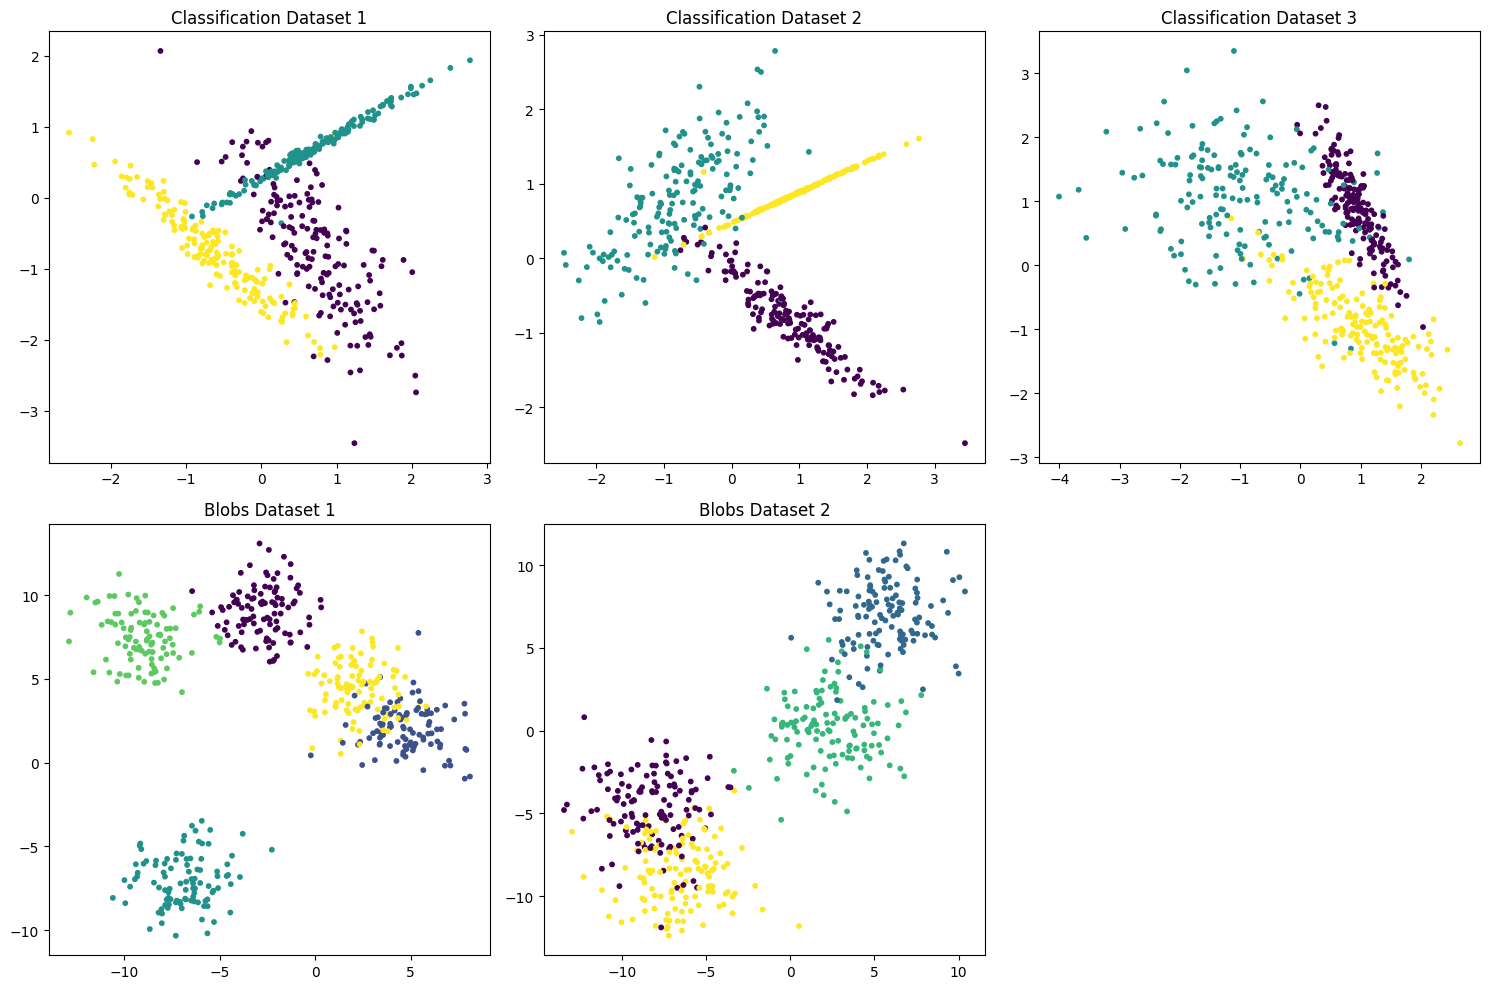

In [1]:
from sklearn.datasets import make_classification, make_blobs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.neighbors import NearestNeighbors
import optuna
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from tabulate import tabulate
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from kneed import KneeLocator
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_samples

# Генерация 3 датасетов с make_classification
np.random.seed(42)
datasets_classification = []
for i in range(3):
    n_classes = np.random.randint(3, 4)
    X, y = make_classification(
        n_samples=500,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=1,
        shift=0.01*i,
        scale=0.7 + i*0.1,
        random_state=42+i
    )
    datasets_classification.append((X, y, f"Classification Dataset {i+1}"))

# Генерация 2 датасетов с make_blobs
datasets_blobs = []
clusters = [5, 4]
for i in range(2):
    n_clusters = clusters[i]
    X, y = make_blobs(n_samples=500, centers=n_clusters, 
                     cluster_std=1.5 + i * 0.6)
    datasets_blobs.append((X, y, f"Blobs Dataset {i+1}"))

# Объединение всех датасетов
all_datasets = datasets_classification + datasets_blobs

# Визуализация сгенерированных датасетов
plt.figure(figsize=(15, 10))
for i, (X, y, title) in enumerate(all_datasets, 1):
    plt.subplot(2, 3, i)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
    plt.title(title)
plt.tight_layout()
plt.show()

Предобработка

In [2]:
data_clf = pd.read_csv('data_classification.csv')

In [3]:
data_clf

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,AgeGroup
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,4
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,4
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,4
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,2
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,45,1,1,110,264,0,0,132,0,1.2,2,0,7,1,3
289,68,1,4,144,193,1,0,141,0,3.4,2,2,7,2,4
290,57,1,4,130,131,0,0,115,1,1.2,2,1,7,3,3
291,57,0,2,130,236,0,2,174,0,0.0,2,1,3,1,3


In [4]:
X_clf = data_clf.iloc[:, :-2].values
y_clf_true = data_clf.iloc[:, -2].values

# Масштабирование данных
scaler = StandardScaler()
X_clf_scaled = scaler.fit_transform(X_clf)

In [5]:
X_clf_scaled

array([[ 0.96297853,  0.67118928, -2.24177258, ...,  2.37153948,
        -0.7044646 ,  0.68650742],
       [ 1.40349799,  0.67118928,  0.89100659, ...,  0.70520598,
         2.62469874, -0.86875037],
       [ 1.40349799,  0.67118928,  0.89100659, ...,  0.70520598,
         1.51497763,  1.20492668],
       ...,
       [ 0.30219935,  0.67118928,  0.89100659, ...,  0.70520598,
         0.40525652,  1.20492668],
       [ 0.30219935, -1.48989269, -1.19751286, ...,  0.70520598,
         0.40525652, -0.86875037],
       [-1.79026805,  0.67118928, -0.15325313, ..., -0.96112751,
        -0.7044646 , -0.86875037]])

Функции для подбора гиперпараметров

In [6]:
def evaluate_clustering(X, labels):
    if len(set(labels)) < 2:
        return -1  # Невалидная кластеризация
    return silhouette_score(X, labels)  # или calinski_harabasz_score

In [7]:
def grid_search_clustering(X, algorithm, param_grid):
    best_score = -1
    best_params = {}
    
    for params in ParameterGrid(param_grid):
        model = algorithm(**params)
        labels = model.fit_predict(X)
        score = evaluate_clustering(X, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
    
    return best_params, best_score


#kmeans_params = {'n_clusters': range(2, 10)}
#dbscan_params = {'eps': np.linspace(0.1, 1.0, 10), 'min_samples': range(3, 10)}
#gmm_params = {'n_components': range(2, 10), 'covariance_type': ['full', 'tied', 'diag', 'spherical']}
#agg_params = {'n_clusters': range(2, 10), 'linkage': ['ward', 'complete', 'average', 'single']}
#affinity_params = {'damping': np.linspace(0.5, 0.95, 10)}

kmeans_params = {'n_clusters': range(2, 15), 'init': ['k-means++', 'random']}
dbscan_params = {'eps': np.linspace(0.1, 2.0, 20), 'min_samples': range(3, 15)}
gmm_params = {'n_components': range(2, 15), 
                  'covariance_type': ['full', 'tied', 'diag', 'spherical']}
agg_params = {'n_clusters': range(2, 15), 
                  'linkage': ['ward', 'complete', 'average', 'single']}
affinity_params = {'damping': np.linspace(0.5, 0.99, 10),
                       'preference': np.linspace(-200, -10, 20)}

In [8]:
def random_search_clustering(X, algorithm, param_distributions, n_iter=50):
    best_score = -1
    best_params = {}
    
    for params in ParameterSampler(param_distributions, n_iter=n_iter):
        model = algorithm(**params)
        labels = model.fit_predict(X)
        score = evaluate_clustering(X, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
    
    return best_params, best_score

In [9]:
def optuna_optimization(X, algorithm, n_trials=100):
    def objective(trial):
        if algorithm == KMeans:
            params = {
                'n_clusters': trial.suggest_int('n_clusters', 2, 10),
                'init': trial.suggest_categorical('init', ['k-means++', 'random'])
            }
        elif algorithm == DBSCAN:
            params = {
                'eps': trial.suggest_float('eps', 0.1, 2.0),
                'min_samples': trial.suggest_int('min_samples', 2, 20)
            }
        elif algorithm == GaussianMixture:
            params = {
                'n_components': trial.suggest_int('n_components', 2, 10),
                'covariance_type': trial.suggest_categorical('covariance_type', 
                               ['full', 'tied', 'diag', 'spherical'])
            }
        elif algorithm == AgglomerativeClustering:
            params = {
                'n_clusters': trial.suggest_int('n_clusters', 2, 10),
                'linkage': trial.suggest_categorical('linkage', 
                           ['ward', 'complete', 'average', 'single'])
            }
        elif algorithm == AffinityPropagation:
            params = {
                'damping': trial.suggest_float('damping', 0.5, 0.99),
                'preference': trial.suggest_float('preference', -200, 0)  # Уменьшил диапазон
            }
        
        model = algorithm(**params)
        
        try:
            labels = model.fit_predict(X)
            # Если все точки в одном кластере или шуме - возвращаем плохой score
            if len(set(labels)) <= 1 or len(set(labels)) >= len(X):
                return -1
            return silhouette_score(X, labels)
        except:
            return -1
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study.best_value

Объеденияем все датасеты

In [10]:
all_datasets.append((X_clf_scaled, y_clf_true, "Real Dataset"))

Подбор гиперпараметров

In [11]:
algorithms = {
    'KMeans': (KMeans, kmeans_params),
    'DBSCAN': (DBSCAN, dbscan_params),
    'GMM': (GaussianMixture, gmm_params),
    'Agglomerative': (AgglomerativeClustering, agg_params),
    'Affinity': (AffinityPropagation, affinity_params)
}

# Создаем структуру для хранения результатов
optuna_results = {
    'datasets': {},
    'best_global': {'score': -1, 'params': None, 'algorithm': None, 'dataset': None}
}


def safe_silhouette_score(X, labels):
    unique_labels = np.unique(labels)
    n_labels = len(unique_labels)
    
    # Проверяем условия для расчета silhouette score
    if n_labels < 2 or n_labels >= len(X):
        return -1  # Возвращаем плохой результат
    
    # Игнорируем шумовые точки (-1) для DBSCAN
    if -1 in unique_labels:
        mask = labels != -1
        X = X[mask]
        labels = labels[mask]
        if len(np.unique(labels)) < 2:
            return -1
    
    try:
        return silhouette_score(X, labels)
    except:
        return -1

def grid_search_clustering(X, algorithm, params):
    best_score = -1
    best_params = None
    
    for param_comb in ParameterGrid(params):
        try:
            model = algorithm(**param_comb).fit(X)
            labels = model.labels_ if hasattr(model, 'labels_') else model.predict(X)
            score = safe_silhouette_score(X, labels)
            
            if score > best_score:
                best_score = score
                best_params = param_comb
        except:
            continue
            
    return best_params, best_score


for dataset_idx, (X, y, dataset_name) in enumerate(all_datasets):
    optuna_results['datasets'][dataset_name] = {}
    
    for algo_name, (algorithm, params) in algorithms.items():
        optuna_params, optuna_score = optuna_optimization(X, algorithm, n_trials=50)
        
        optuna_results['datasets'][dataset_name][algo_name] = {
            'params': optuna_params,
            'score': optuna_score
        }
        
        if optuna_score > optuna_results['best_global']['score']:
            optuna_results['best_global'] = {
                'score': optuna_score,
                'params': optuna_params,
                'algorithm': algo_name,
                'dataset': dataset_name
            }

[I 2025-05-25 10:18:32,266] A new study created in memory with name: no-name-1bad6815-8d22-4d46-a097-61c186acb9e4
[I 2025-05-25 10:18:32,391] Trial 0 finished with value: 0.43470510580798694 and parameters: {'n_clusters': 8, 'init': 'random'}. Best is trial 0 with value: 0.43470510580798694.
[I 2025-05-25 10:18:32,422] Trial 1 finished with value: 0.43871437393371004 and parameters: {'n_clusters': 8, 'init': 'random'}. Best is trial 1 with value: 0.43871437393371004.
[I 2025-05-25 10:18:32,452] Trial 2 finished with value: 0.43214032546579495 and parameters: {'n_clusters': 6, 'init': 'random'}. Best is trial 1 with value: 0.43871437393371004.
[I 2025-05-25 10:18:32,484] Trial 3 finished with value: 0.4336305605157564 and parameters: {'n_clusters': 8, 'init': 'random'}. Best is trial 1 with value: 0.43871437393371004.
[I 2025-05-25 10:18:32,513] Trial 4 finished with value: 0.4373893978483244 and parameters: {'n_clusters': 9, 'init': 'random'}. Best is trial 1 with value: 0.438714373933

In [12]:
optuna_results

{'datasets': {'Classification Dataset 1': {'KMeans': {'params': {'n_clusters': 3,
     'init': 'k-means++'},
    'score': 0.47142125861981615},
   'DBSCAN': {'params': {'eps': 0.5121202910961136, 'min_samples': 6},
    'score': 0.5096840201243331},
   'GMM': {'params': {'n_components': 3, 'covariance_type': 'spherical'},
    'score': 0.47045839317615645},
   'Agglomerative': {'params': {'n_clusters': 3, 'linkage': 'ward'},
    'score': 0.45739032220163006},
   'Affinity': {'params': {'damping': 0.9444872982073704,
     'preference': -77.8955578772302},
    'score': 0.47607658638801975}},
  'Classification Dataset 2': {'KMeans': {'params': {'n_clusters': 3,
     'init': 'k-means++'},
    'score': 0.5078817476175937},
   'DBSCAN': {'params': {'eps': 1.1199952743726385, 'min_samples': 14},
    'score': 0.5603565772398208},
   'GMM': {'params': {'n_components': 3, 'covariance_type': 'diag'},
    'score': 0.46950589869733617},
   'Agglomerative': {'params': {'n_clusters': 2, 'linkage': 'ave

Визуализация


Визуализация


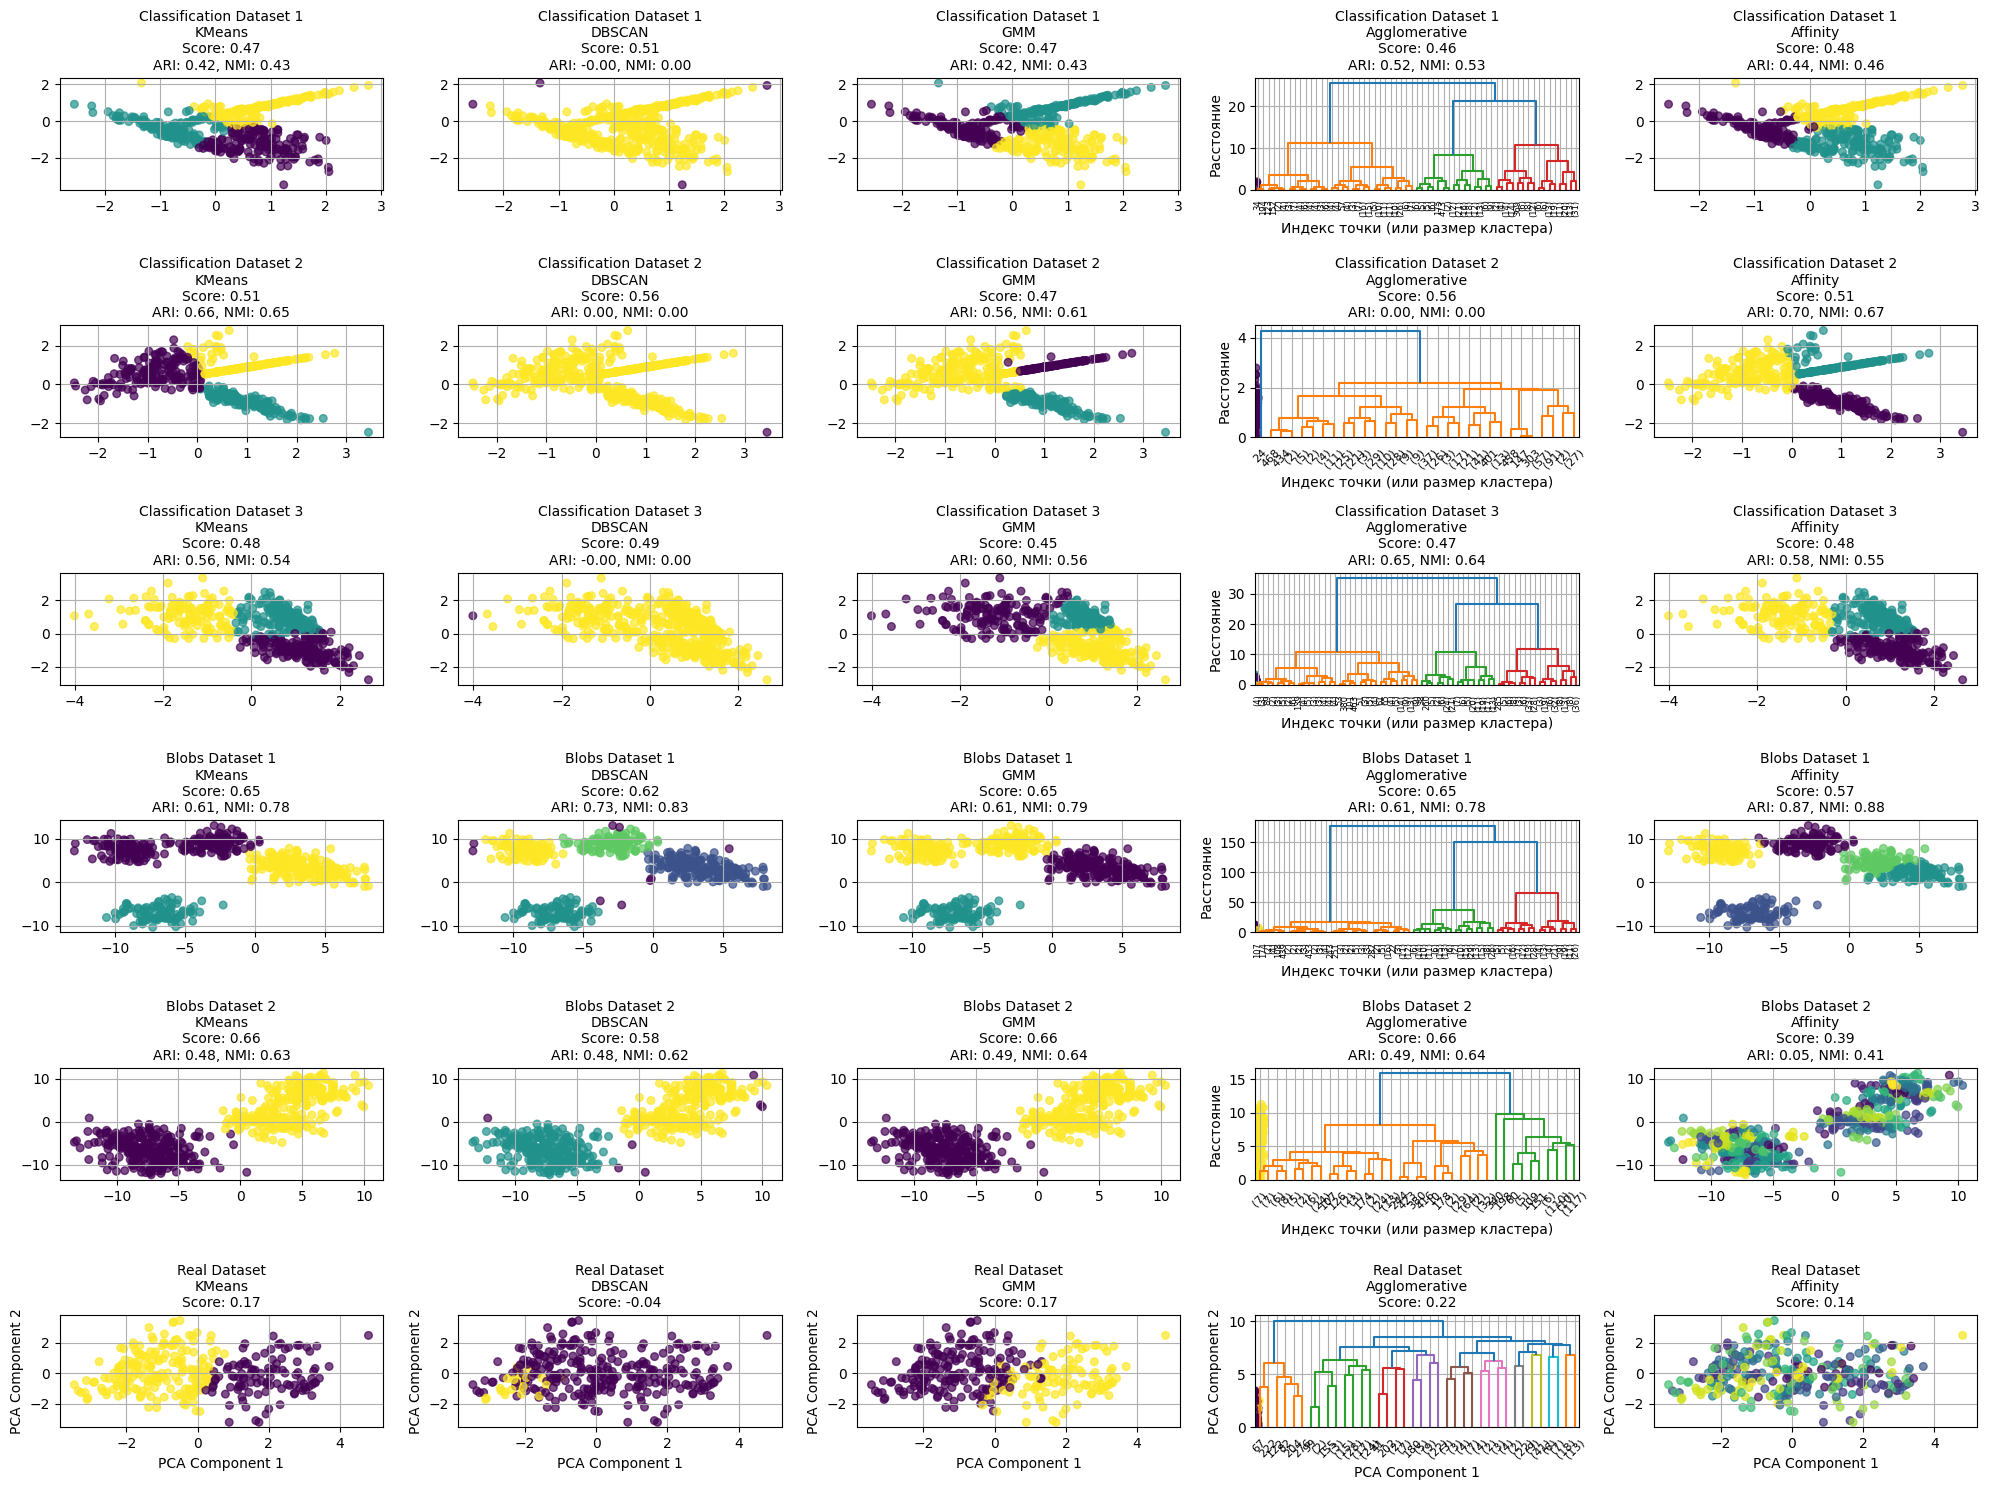

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_real_pca = pca.fit_transform(X_clf_scaled)

# Визуализация для синтетических данных (optuna_results)
print("\nВизуализация")
plt.figure(figsize=(20, 15))
for i, (dataset_name, algo_results) in enumerate(optuna_results['datasets'].items(), 1):
    X = [X for X, _, name in all_datasets if name == dataset_name][0]
    y_true = [y for _, y, name in all_datasets if name == dataset_name][0] if dataset_name != 'Real Dataset' else None
    
    for j, (algo_name, result) in enumerate(algo_results.items(), 1):
        plt.subplot(len(optuna_results['datasets']), len(algorithms), (i-1)*len(algorithms)+j)
        
        # Получаем модель с лучшими параметрами
        if algo_name == 'GMM':
            model = algorithms[algo_name][0](**result['params'])
            labels = model.fit_predict(X)
        else:
            model = algorithms[algo_name][0](**result['params'])
            labels = model.fit_predict(X)

        if algo_name == 'Agglomerative':
            # Создаем linkage matrix
            Z = linkage(X, method=result['params']['linkage'], 
                        metric=result['params']['affinity'] if 'affinity' in result['params'] else 'euclidean')
            
            # Рисуем дендрограмму
            dendrogram(Z, truncate_mode='level', p=5 if X.shape[0] > 100 else 10)
            plt.title(f"{dataset_name}\n{algo_name}\nLinkage: {result['params']['linkage']}", fontsize=10)
            plt.xlabel("Индекс точки (или размер кластера)")
            plt.ylabel("Расстояние")
            
        if dataset_name != 'Real Dataset':
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.7)
            
            # Вычисляем метрики точности
            ari = adjusted_rand_score(y_true, labels) if y_true is not None else None
            nmi = normalized_mutual_info_score(y_true, labels) if y_true is not None else None
            
            title = f"{dataset_name}\n{algo_name}\nScore: {result['score']:.2f}"
            if ari is not None:
                title += f"\nARI: {ari:.2f}, NMI: {nmi:.2f}"
            plt.title(title, fontsize=10)
            plt.grid(True)
            
        else:
            plt.scatter(X_real_pca[:, 0], X_real_pca[:, 1], c=labels, cmap='viridis', s=30, alpha=0.7)
            plt.title(f"{dataset_name}\n{algo_name}\nScore: {result['score']:.2f}", fontsize=10)
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.grid(True)
        
plt.tight_layout()
plt.show()


Дендрограммы Agglomerative Clustering


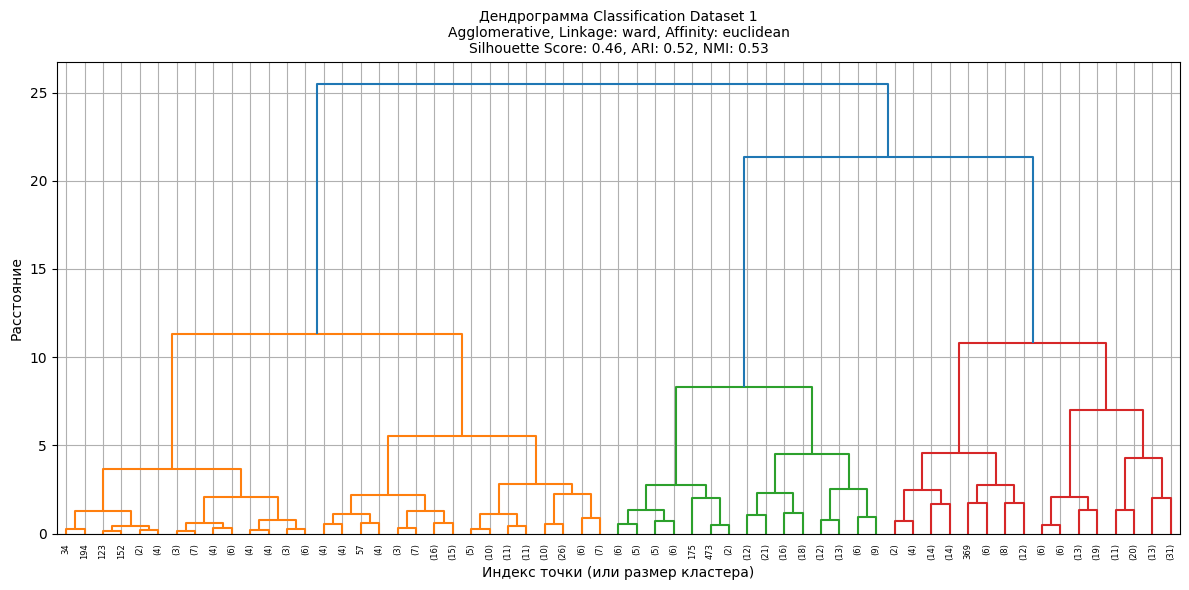


=== Анализ Agglomerative Clustering для Classification Dataset 1 ===
Оптимальные параметры: {'n_clusters': 3, 'linkage': 'ward'}
Число кластеров: 3
Размеры кластеров: [187, 180, 133]

Метрики качества:
Silhouette Score: 0.457
Adjusted Rand Index: 0.515
Normalized Mutual Info: 0.529
--------------------------------------------------


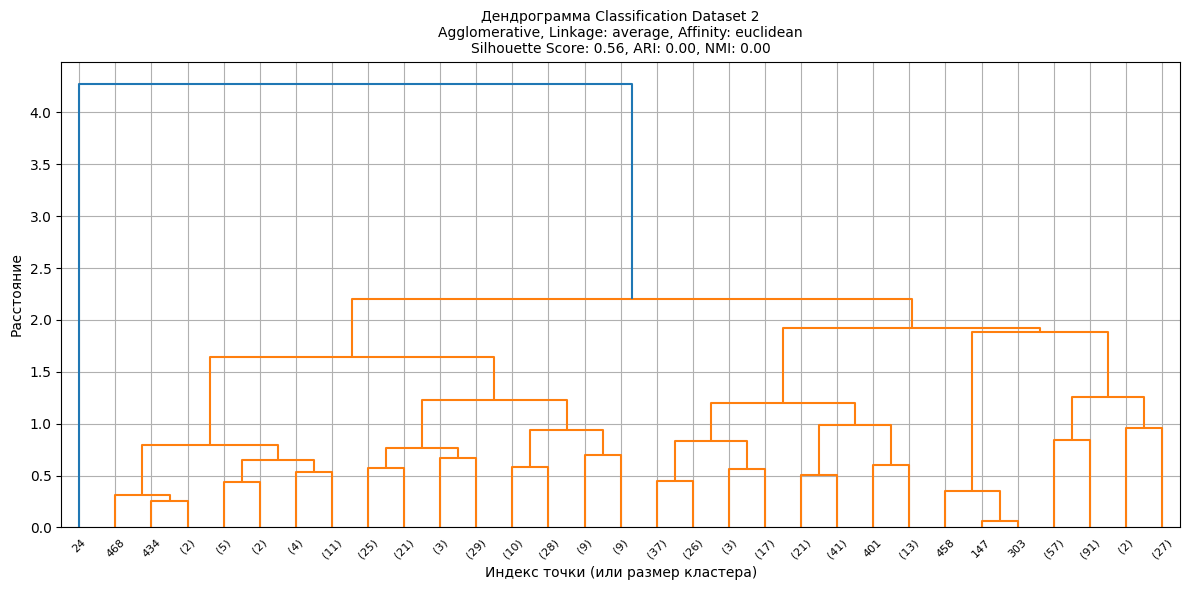


=== Анализ Agglomerative Clustering для Classification Dataset 2 ===
Оптимальные параметры: {'n_clusters': 2, 'linkage': 'average'}
Число кластеров: 2
Размеры кластеров: [499, 1]

Метрики качества:
Silhouette Score: 0.560
Adjusted Rand Index: 0.000
Normalized Mutual Info: 0.004
--------------------------------------------------


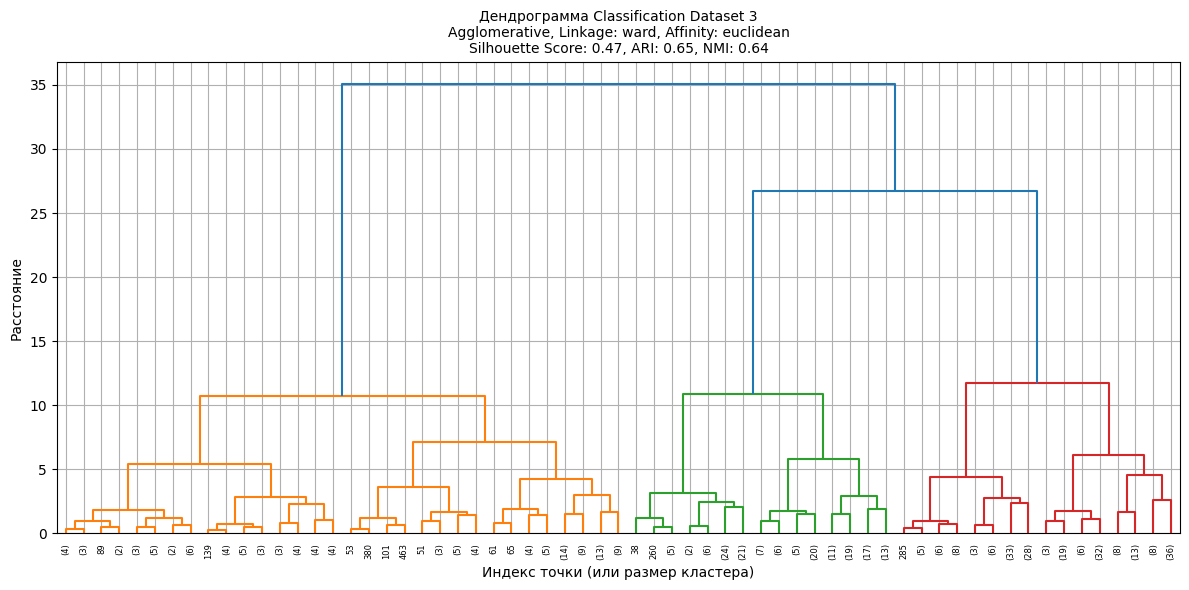


=== Анализ Agglomerative Clustering для Classification Dataset 3 ===
Оптимальные параметры: {'n_clusters': 3, 'linkage': 'ward'}
Число кластеров: 3
Размеры кластеров: [215, 127, 158]

Метрики качества:
Silhouette Score: 0.465
Adjusted Rand Index: 0.649
Normalized Mutual Info: 0.639
--------------------------------------------------


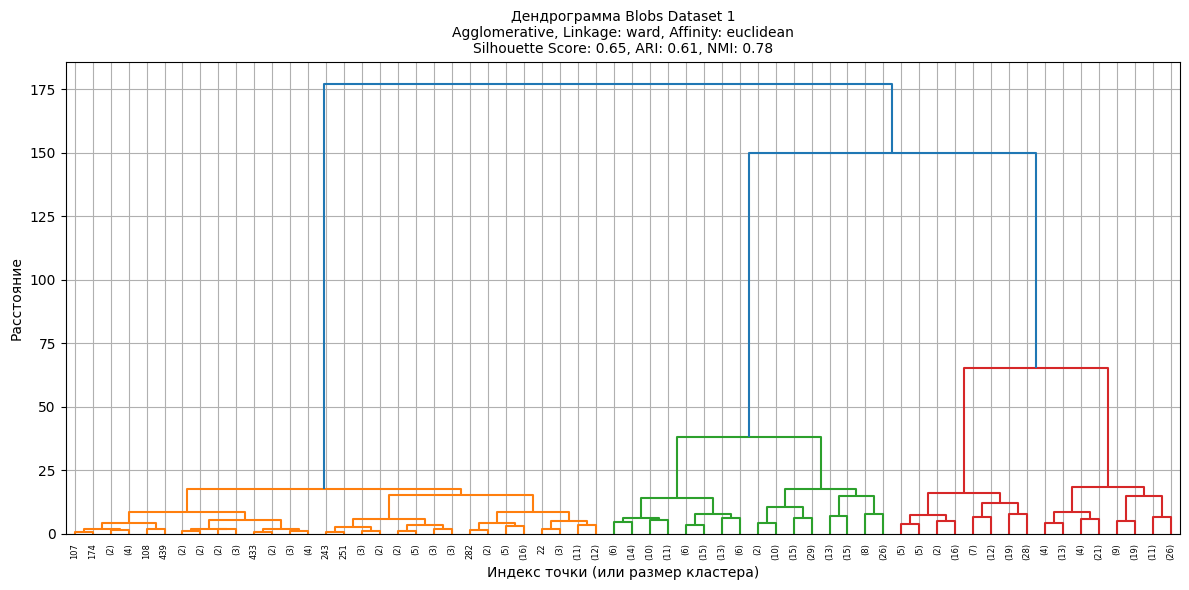


=== Анализ Agglomerative Clustering для Blobs Dataset 1 ===
Оптимальные параметры: {'n_clusters': 3, 'linkage': 'ward'}
Число кластеров: 3
Размеры кластеров: [201, 100, 199]

Метрики качества:
Silhouette Score: 0.653
Adjusted Rand Index: 0.610
Normalized Mutual Info: 0.783
--------------------------------------------------


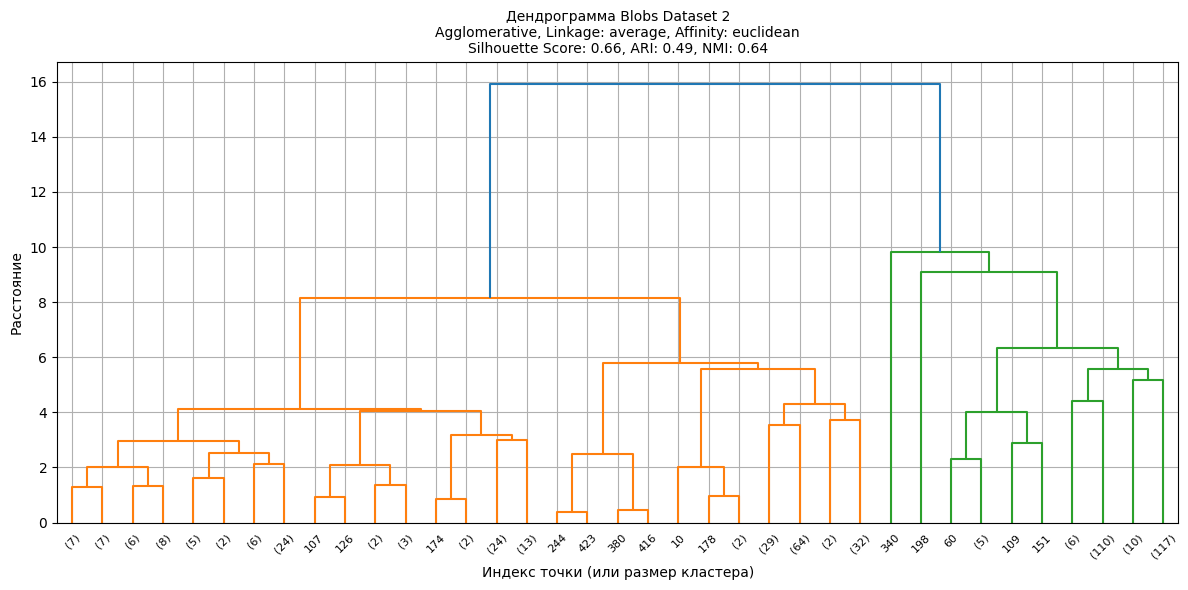


=== Анализ Agglomerative Clustering для Blobs Dataset 2 ===
Оптимальные параметры: {'n_clusters': 2, 'linkage': 'average'}
Число кластеров: 2
Размеры кластеров: [253, 247]

Метрики качества:
Silhouette Score: 0.658
Adjusted Rand Index: 0.487
Normalized Mutual Info: 0.639
--------------------------------------------------


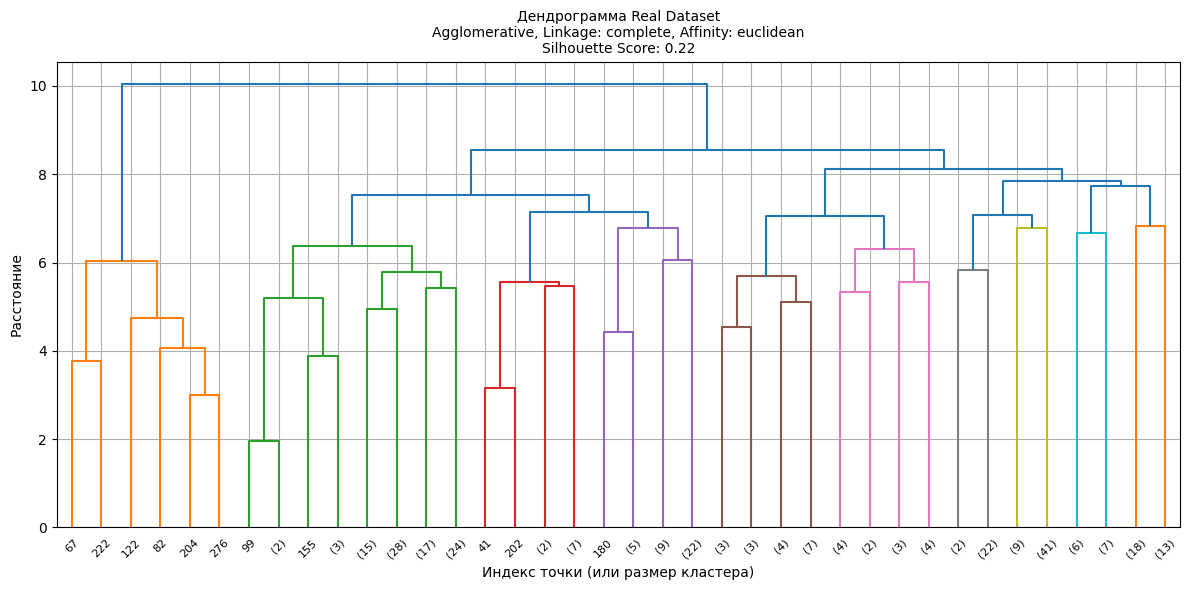


=== Анализ Agglomerative Clustering для Real Dataset ===
Оптимальные параметры: {'n_clusters': 2, 'linkage': 'complete'}
Число кластеров: 2
Размеры кластеров: [287, 6]

Метрики качества:
Silhouette Score: 0.215
--------------------------------------------------


In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Визуализация только дендрограмм для Agglomerative Clustering
print("\nДендрограммы Agglomerative Clustering")

for dataset_name, algo_results in optuna_results['datasets'].items():
    # Проверяем, есть ли Agglomerative в результатах для этого датасета
    if 'Agglomerative' not in algo_results:
        continue
        
    X = [X for X, _, name in all_datasets if name == dataset_name][0]
    y_true = [y for _, y, name in all_datasets if name == dataset_name][0] if dataset_name != 'Real Dataset' else None
    result = algo_results['Agglomerative']
    
    # Создаем новую фигуру для каждой дендрограммы
    plt.figure(figsize=(12, 6))
    
    # Создаем linkage matrix
    Z = linkage(X, method=result['params']['linkage'], 
               metric=result['params']['affinity'] if 'affinity' in result['params'] else 'euclidean')
    
    # Рисуем дендрограмму
    dendrogram(Z, truncate_mode='level', p=5 if X.shape[0] > 100 else 10)
    
    # Добавляем заголовок с информацией
    title = f"Дендрограмма {dataset_name}\n"
    title += f"Agglomerative, Linkage: {result['params']['linkage']}, "
    title += f"Affinity: {result['params'].get('affinity', 'euclidean')}\n"
    title += f"Silhouette Score: {result['score']:.2f}"
    
    if y_true is not None:
        model = algorithms['Agglomerative'][0](**result['params'])
        labels = model.fit_predict(X)
        ari = adjusted_rand_score(y_true, labels)
        nmi = normalized_mutual_info_score(y_true, labels)
        title += f", ARI: {ari:.2f}, NMI: {nmi:.2f}"
    
    plt.title(title, fontsize=10)
    plt.xlabel("Индекс точки (или размер кластера)")
    plt.ylabel("Расстояние")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Анализ кластеров (текстовый вывод)
    print(f"\n=== Анализ Agglomerative Clustering для {dataset_name} ===")
    print(f"Оптимальные параметры: {result['params']}")
    
    model = algorithms['Agglomerative'][0](**result['params'])
    labels = model.fit_predict(X)
    
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    print(f"Число кластеров: {n_clusters}")
    
    if -1 in unique_labels:
        print(f"Точек шума: {np.sum(labels == -1)} ({np.sum(labels == -1)/len(labels):.1%})")
    
    # Размеры кластеров
    cluster_sizes = [np.sum(labels == label) for label in unique_labels if label != -1]
    print(f"Размеры кластеров: {cluster_sizes}")
    
    # Метрики качества
    print("\nМетрики качества:")
    print(f"Silhouette Score: {result['score']:.3f}")
    
    if y_true is not None:
        print(f"Adjusted Rand Index: {ari:.3f}")
        print(f"Normalized Mutual Info: {nmi:.3f}")
    
    print("-"*50)

Визуализация «метода локтя» и графика силуэтов для сравнения с подбором гиперпараметров


=== Анализ для датасета: Classification Dataset 1 ===



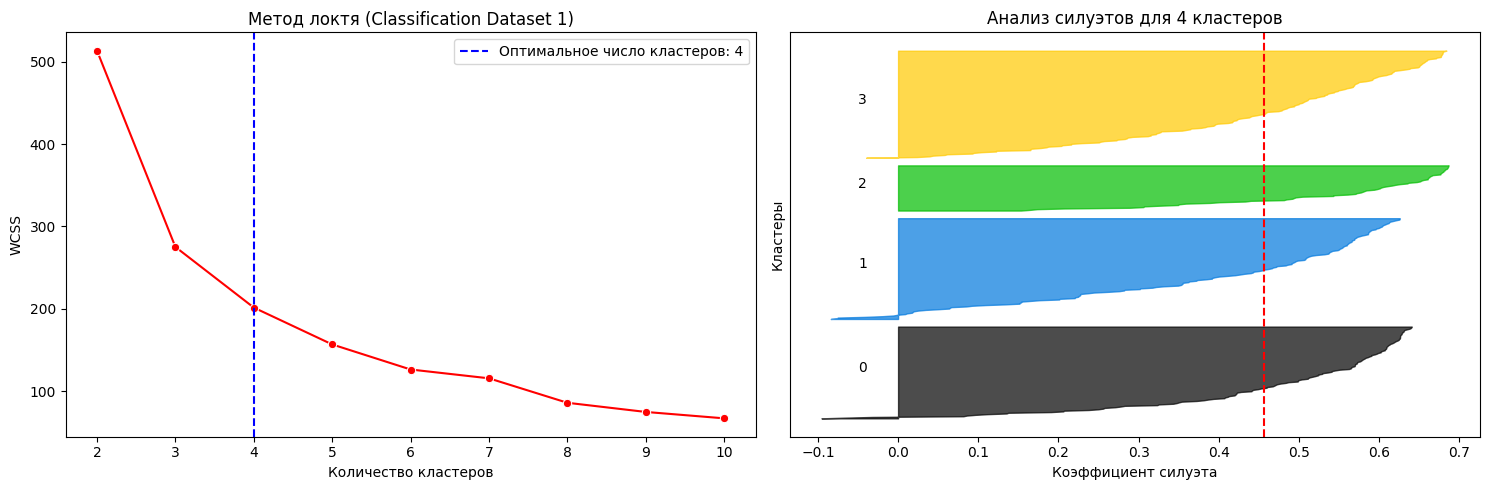

Оптимальное число кластеров (метод локтя): 4
Лучший средний коэффициент силуэта: 0.471 при 3 кластерах

Распределение точек по кластерам:
{0: 133, 1: 146, 2: 66, 3: 155}

=== Анализ для датасета: Classification Dataset 2 ===



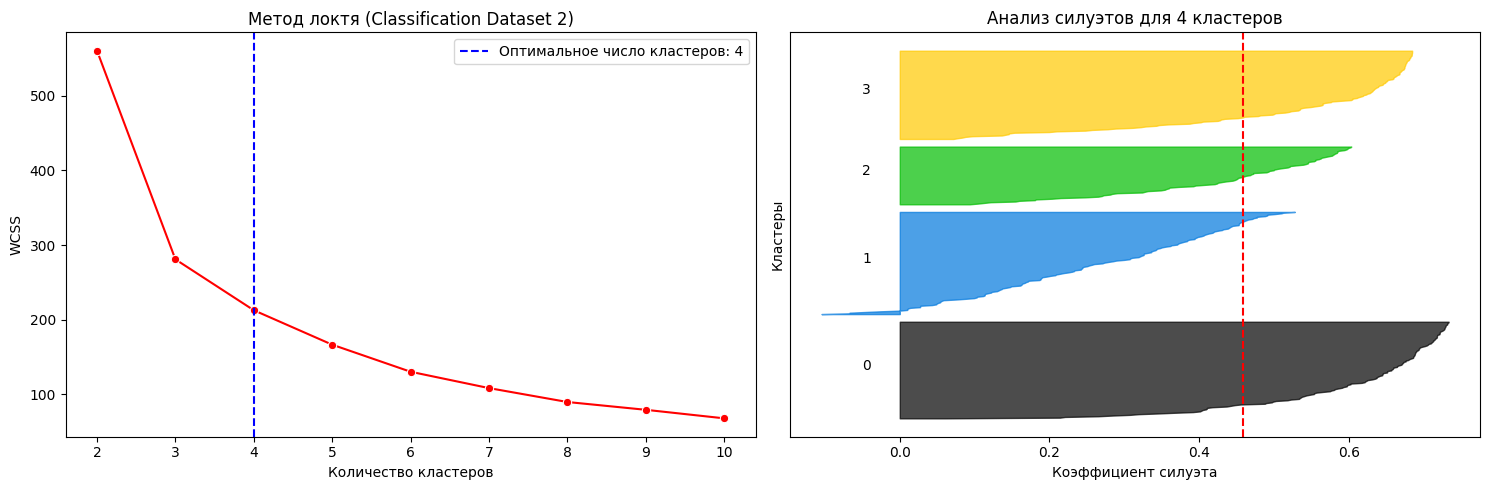

Оптимальное число кластеров (метод локтя): 4
Лучший средний коэффициент силуэта: 0.508 при 3 кластерах

Распределение точек по кластерам:
{0: 140, 1: 148, 2: 84, 3: 128}

=== Анализ для датасета: Classification Dataset 3 ===



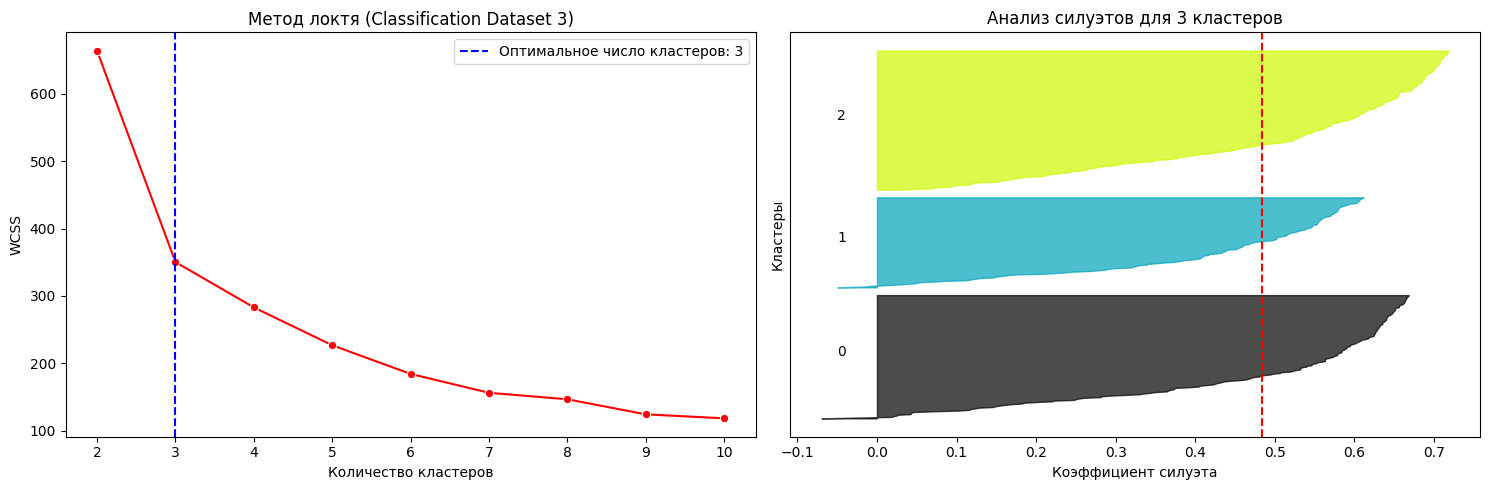

Оптимальное число кластеров (метод локтя): 3
Лучший средний коэффициент силуэта: 0.483 при 3 кластерах

Распределение точек по кластерам:
{0: 175, 1: 128, 2: 197}

=== Анализ для датасета: Blobs Dataset 1 ===



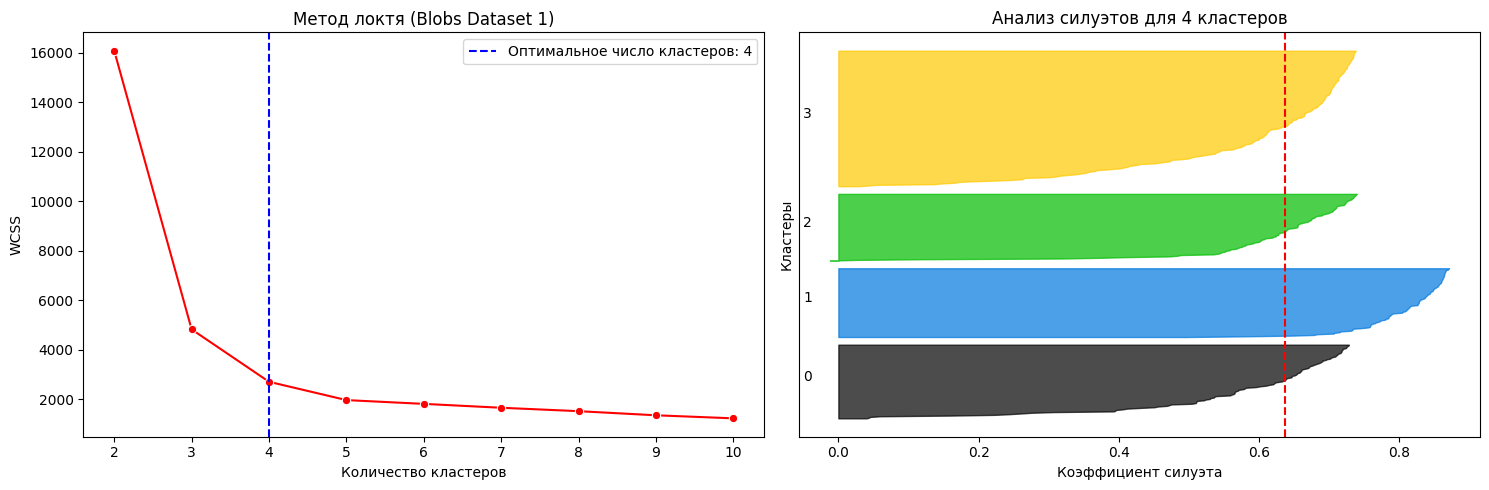

Оптимальное число кластеров (метод локтя): 4
Лучший средний коэффициент силуэта: 0.654 при 3 кластерах

Распределение точек по кластерам:
{0: 107, 1: 100, 2: 97, 3: 196}

=== Анализ для датасета: Blobs Dataset 2 ===



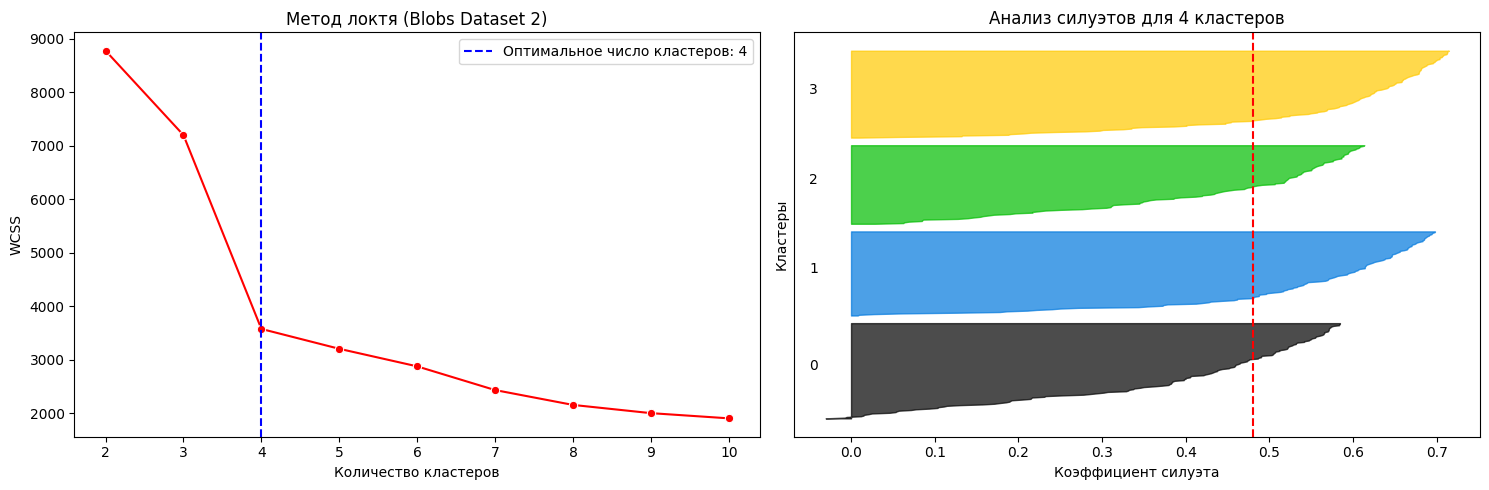

Оптимальное число кластеров (метод локтя): 4
Лучший средний коэффициент силуэта: 0.658 при 2 кластерах

Распределение точек по кластерам:
{0: 138, 1: 122, 2: 114, 3: 126}

=== Анализ для датасета: Real Dataset ===



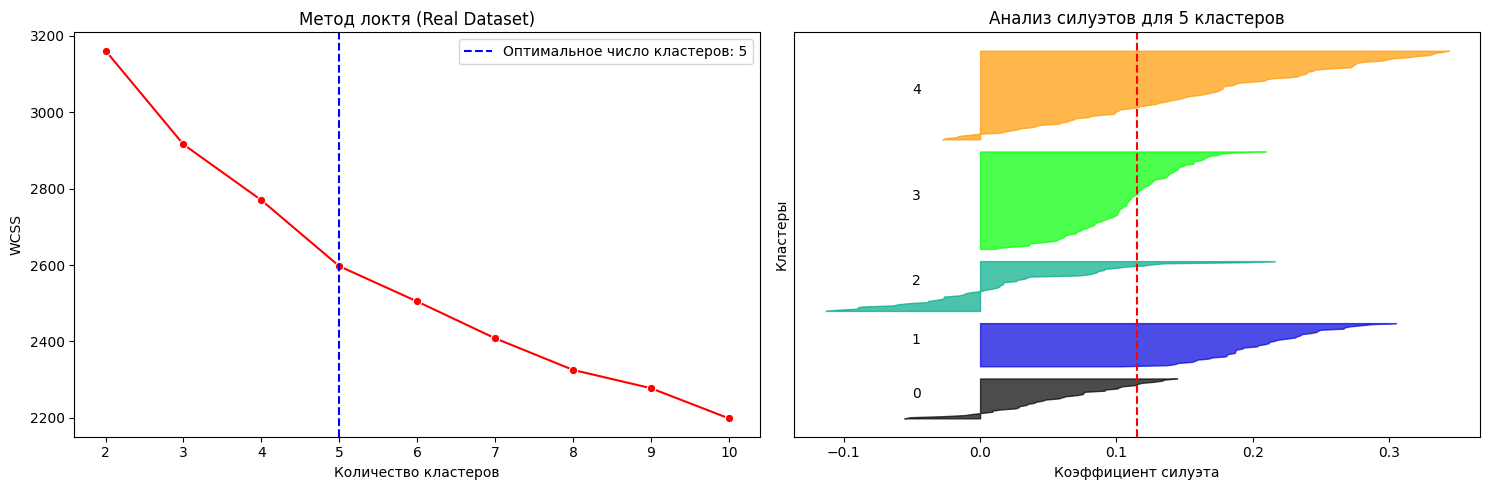

Оптимальное число кластеров (метод локтя): 5
Лучший средний коэффициент силуэта: 0.168 при 2 кластерах

Распределение точек по кластерам:
{0: 96, 1: 53, 2: 48, 3: 96}

Первые 5 строк датафрейма с метками кластеров:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca  thal  num  AgeGroup  Cluster_id  
0   0     6    0         4           2  
1   3     3    2         4           0  
2   2     7    1         4           0  
3   0     3    0         2           3  
4   0     3    0         3           1  


In [14]:
def analyze_kmeans_for_datasets(datasets):
    for X, y, dataset_name in datasets:
        print(f"\n=== Анализ для датасета: {dataset_name} ===\n")
        
        # Метод локтя
        wcss = []
        for i in range(2, 11):  # Начинаем с 2 кластеров для силуэта
            kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
            kmeans.fit(X)
            wcss.append(kmeans.inertia_)
        
        # Визуализация метода локтя
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        sns.lineplot(x=range(2, 11), y=wcss, marker='o', color='red')
        plt.title(f"Метод локтя ({dataset_name})")
        plt.xlabel("Количество кластеров")
        plt.ylabel("WCSS")
        
        # Автоматическое определение "локтя"
        kl = KneeLocator(range(2, 11), wcss, curve='convex', direction='decreasing')
        optimal_clusters = kl.elbow
        plt.axvline(x=optimal_clusters, linestyle='--', color='blue', 
                   label=f'Оптимальное число кластеров: {optimal_clusters}')
        plt.legend()
        
        # Анализ силуэтов
        plt.subplot(1, 2, 2)
        silhouette_scores = []
        for n_clusters in range(2, 11):
            clusterer = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = clusterer.fit_predict(X)
            
            # Средний коэффициент силуэта
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores.append(silhouette_avg)
            
            # Визуализация для оптимального числа кластеров
            if n_clusters == optimal_clusters:
                sample_silhouette_values = silhouette_samples(X, cluster_labels)
                
                y_lower = 10
                for i in range(n_clusters):
                    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
                    ith_cluster_silhouette_values.sort()
                    
                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i
                    
                    color = cm.nipy_spectral(float(i) / n_clusters)
                    plt.fill_betweenx(np.arange(y_lower, y_upper),
                                    0, ith_cluster_silhouette_values,
                                    facecolor=color, edgecolor=color, alpha=0.7)
                    
                    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                    y_lower = y_upper + 10
                
                plt.axvline(x=silhouette_avg, color="red", linestyle="--")
                plt.yticks([])
                plt.xlabel("Коэффициент силуэта")
                plt.ylabel("Кластеры")
                plt.title(f"Анализ силуэтов для {n_clusters} кластеров")
        
        plt.tight_layout()
        plt.show()
        
        # Вывод оптимального числа кластеров
        print(f"Оптимальное число кластеров (метод локтя): {optimal_clusters}")
        print(f"Лучший средний коэффициент силуэта: {max(silhouette_scores):.3f} при {np.argmax(silhouette_scores)+2} кластерах")
        
        # Кластеризация с оптимальным числом кластеров
        optimal_n = optimal_clusters if dataset_name != 'Real Dataset' else 4  # Фиксируем 4 для реальных данных
        kmeans = KMeans(n_clusters=optimal_n, random_state=42)
        labels = kmeans.fit_predict(X)
        
        # Распределение точек по кластерам
        unique, counts = np.unique(labels, return_counts=True)
        print("\nРаспределение точек по кластерам:")
        print(dict(zip(unique, counts)))
        
        # Для реальных данных добавляем метки кластеров
        if dataset_name == 'Real Dataset':
            data_clf['Cluster_id'] = labels
            print("\nПервые 5 строк датафрейма с метками кластеров:")
            print(data_clf.head())

# Применяем анализ ко всем датасетам
analyze_kmeans_for_datasets(all_datasets)

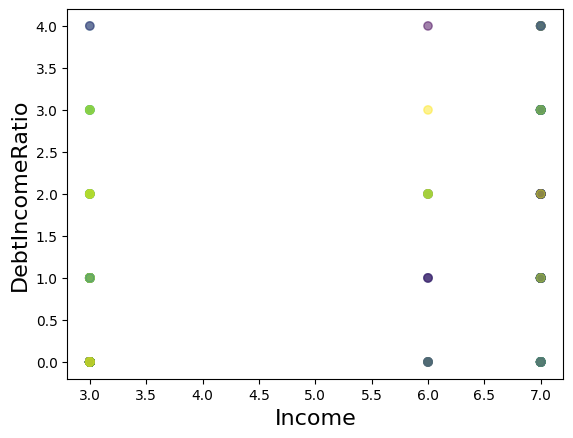

In [15]:
plt.scatter(data_clf.iloc[:, 12], data_clf.iloc[:, 13], c=labels, alpha=0.5)
plt.xlabel('Income', fontsize=16)
plt.ylabel('DebtIncomeRatio', fontsize=16)

plt.show()

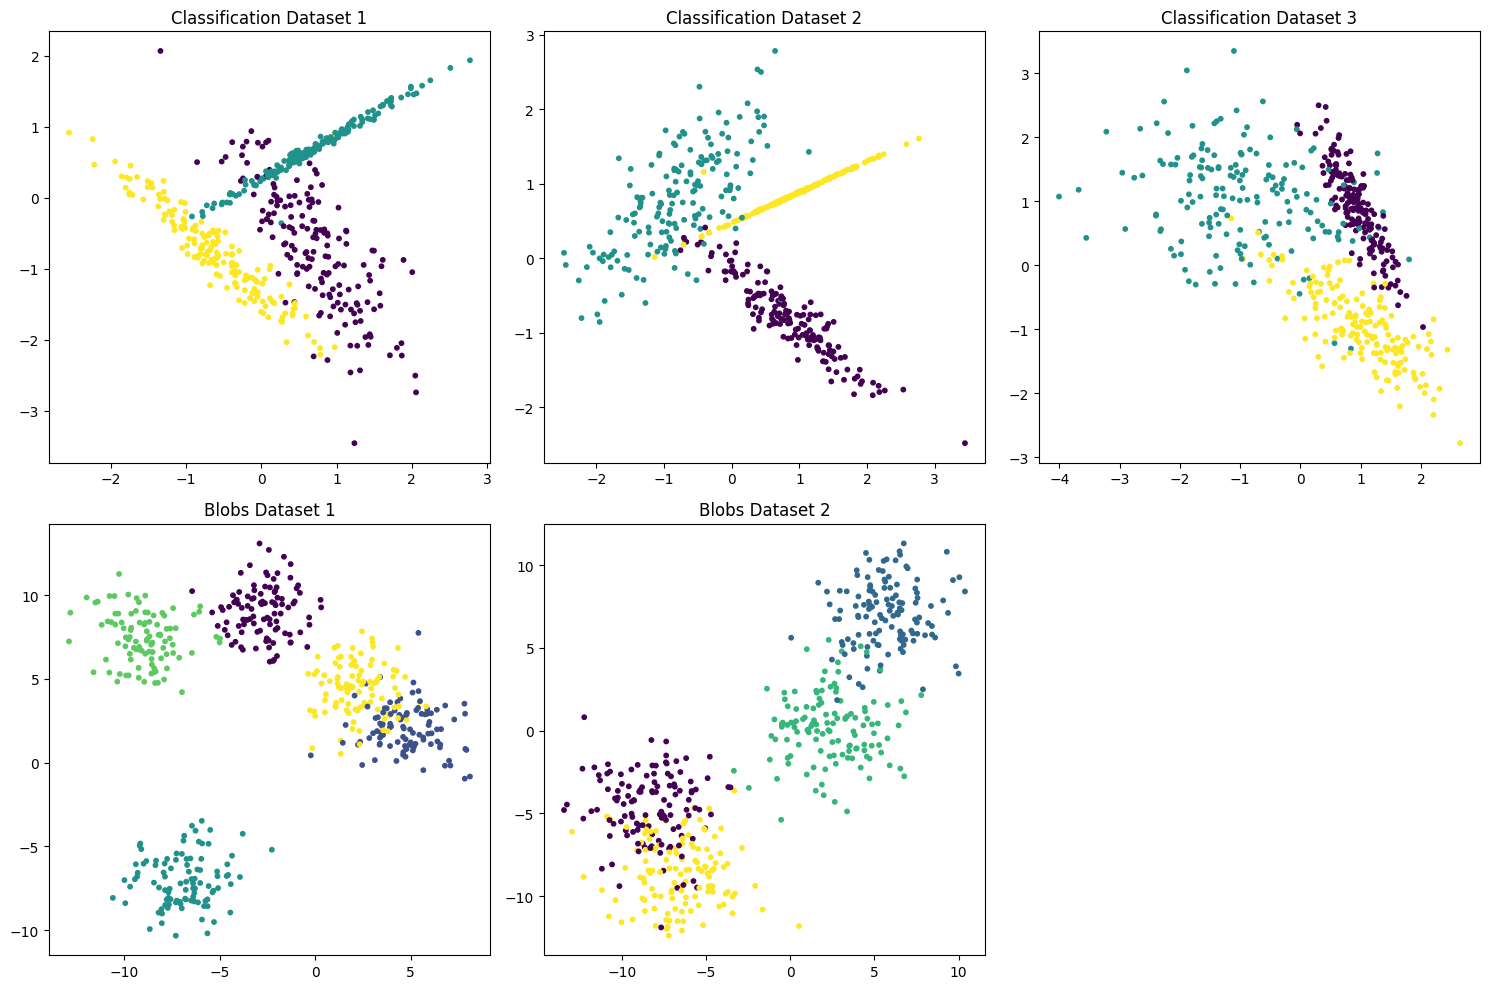

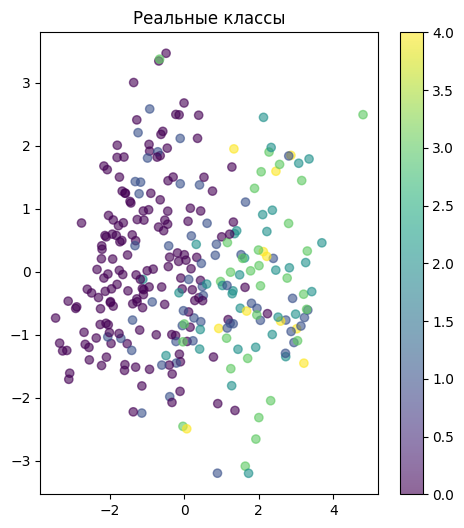

In [16]:
plt.figure(figsize=(15, 10))
for i, (X, y, title) in enumerate(all_datasets, 1):
    if title != 'Real Dataset': 
        plt.subplot(2, 3, i)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
        plt.title(title)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_real_pca[:, 0], X_real_pca[:, 1], c=y_clf_true, cmap='viridis', alpha=0.6)
plt.title('Реальные классы')
plt.colorbar()

In [17]:
cluster_stats = data_clf.groupby('Cluster_id').describe()
display(cluster_stats)

age                                                       sex  \
           count       mean       std   min    25%   50%   75%   max count   
Cluster_id                                                                   
0           96.0  58.104167  7.591518  35.0  54.75  58.5  63.0  77.0  96.0   
1           53.0  50.811321  8.622548  34.0  44.00  51.0  57.0  71.0  53.0   
2           48.0  61.479167  6.314420  51.0  57.75  61.0  66.0  76.0  48.0   
3           96.0  48.697917  7.554880  29.0  43.00  48.0  54.0  68.0  96.0   

                      ...  num      AgeGroup                                \
                mean  ...  75%  max    count      mean       std  min  25%   
Cluster_id            ...                                                    
0           0.833333  ...  3.0  4.0     96.0  3.364583  0.525553  2.0  3.0   
1           0.000000  ...  0.0  1.0     53.0  3.056604  0.496724  2.0  3.0   
2           0.541667  ...  1.0  3.0     48.0  3.520833  0.504852  3.0  3.0   
3           1.000000  ...  1.0  4.0     96.0  2.927083  0.390541  2.0  3.0   

                           
            50%  75%  max  
Cluster_id                 
0           3.0  4.0  4.0  
1           3.0  3.0  4.0  
2           4.0  4.0  4.0  
3           3.0  3.0  4.0  

[4 rows x 120 columns]

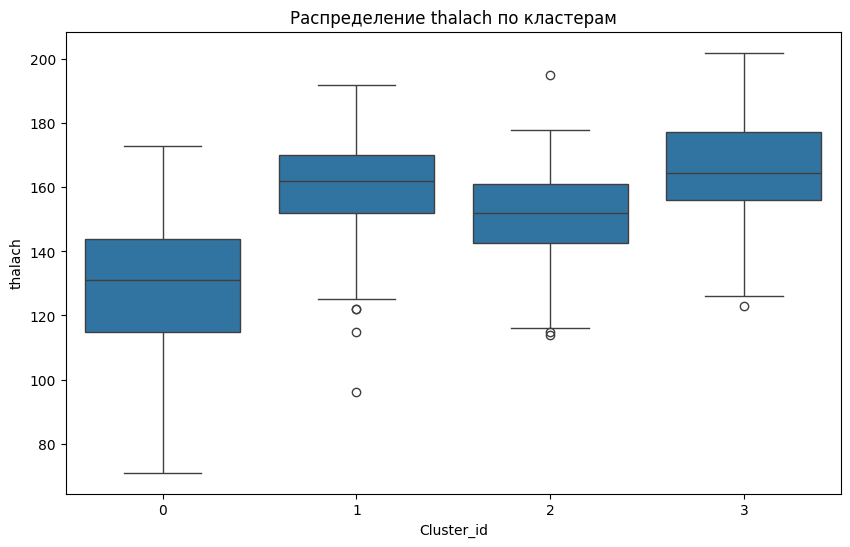

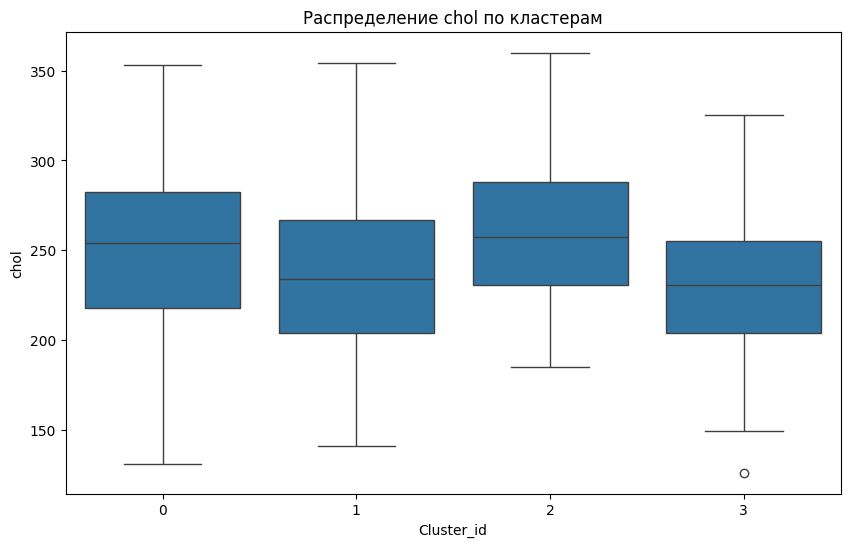

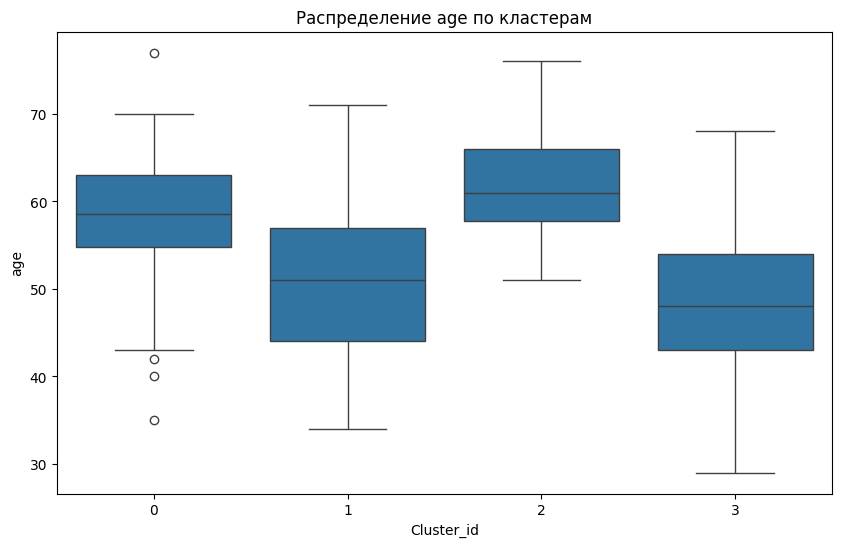

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = ['thalach', 'chol', 'age']  

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_id', y=feature, data=data_clf)
    plt.title(f'Распределение {feature} по кластерам')
    plt.show()

Своя реализация KMeans

In [19]:
from kmeans import CustomKMeans

In [20]:
def visualize_and_analyze_clusters(optuna_results, all_datasets, algorithms, X_clf_scaled=None, y_clf_true=None):
    if X_clf_scaled is not None:
        pca = PCA(n_components=2)
        X_real_pca = pca.fit_transform(X_clf_scaled)
    
    # 1. Визуализация результатов
    plt.figure(figsize=(20, 15))
    for i, (dataset_name, algo_results) in enumerate(optuna_results['datasets'].items(), 1):
        X = [X for X, _, name in all_datasets if name == dataset_name][0]
        y_true = [y for _, y, name in all_datasets if name == dataset_name][0] if dataset_name != 'Real Dataset' else y_clf_true
        
        for j, (algo_name, result) in enumerate(algo_results.items(), 1):
            plt.subplot(len(optuna_results['datasets']), len(algorithms), (i-1)*len(algorithms)+j)
            
            model = algorithms[algo_name][0](**result['params'])
            labels = model.fit_predict(X)

            if dataset_name != 'Real Dataset':
                plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.7)
                ari = adjusted_rand_score(y_true, labels) if y_true is not None else None
                nmi = normalized_mutual_info_score(y_true, labels) if y_true is not None else None
                
                title = f"{dataset_name}\n{algo_name}\nScore: {result['score']:.2f}"
                if ari is not None:
                    title += f"\nARI: {ari:.2f}, NMI: {nmi:.2f}"
                plt.title(title, fontsize=10)
            else:
                plt.scatter(X_real_pca[:, 0], X_real_pca[:, 1], c=labels, cmap='viridis', s=30, alpha=0.7)
                if y_clf_true is not None:
                    ari = adjusted_rand_score(y_clf_true, labels)
                    nmi = normalized_mutual_info_score(y_clf_true, labels)
                    title = f"{dataset_name}\n{algo_name}\nScore: {result['score']:.2f}\nARI: {ari:.2f}, NMI: {nmi:.2f}"
                else:
                    title = f"{dataset_name}\n{algo_name}\nScore: {result['score']:.2f}"
                plt.title(title, fontsize=10)
            plt.grid(True)
            
    plt.tight_layout()
    plt.show()
    
    # 2. Создаем DataFrame с результатами
    results = []
    
    for dataset_name, algo_results in optuna_results['datasets'].items():
        X = [X for X, _, name in all_datasets if name == dataset_name][0]
        y_true = [y for _, y, name in all_datasets if name == dataset_name][0] if dataset_name != 'Real Dataset' else y_clf_true

        for algo_name, result in algo_results.items():
            model = algorithms[algo_name][0](**result['params'])
            labels = model.fit_predict(X)
            
            unique_labels = np.unique(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            
            row = {
                'Dataset': dataset_name,
                'Algorithm': algo_name,
                'Silhouette Score': result['score'],
                'Calinski-Harabasz': calinski_harabasz_score(X, labels)
            }
            
            if y_true is not None:
                row['ARI'] = adjusted_rand_score(y_true, labels)
                row['NMI'] = normalized_mutual_info_score(y_true, labels)
            
            results.append(row)
    
    display(pd.DataFrame(results))

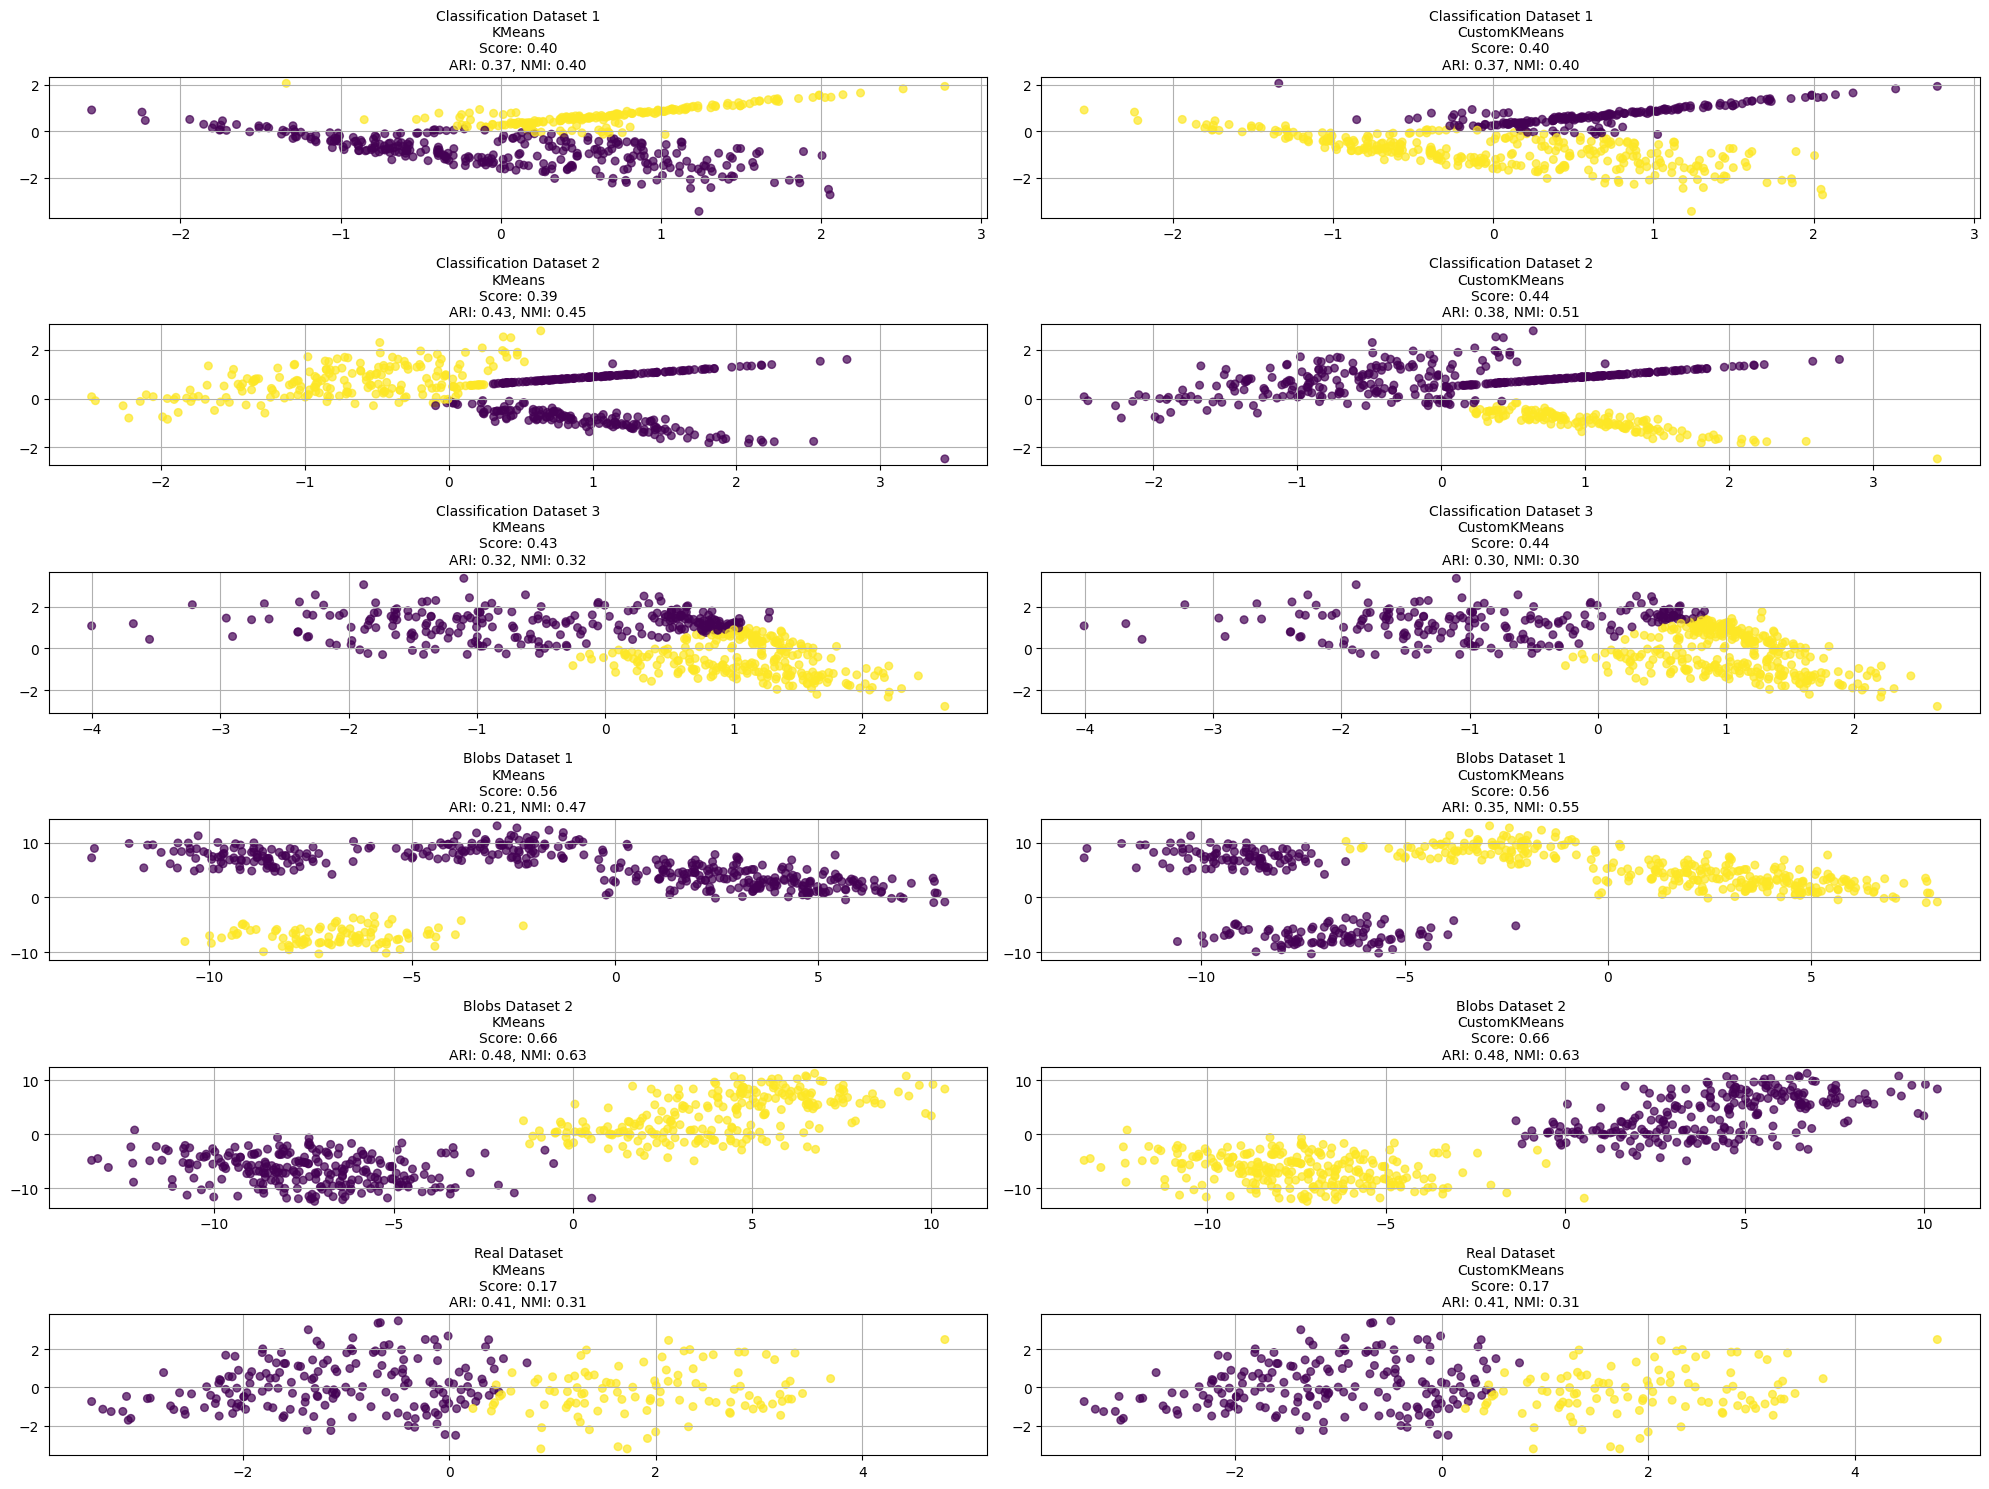

,Dataset,Algorithm,Silhouette Score,Calinski-Harabasz,ARI,NMI
0,Classification Dataset 1,KMeans,0.395087,320.767558,0.369284,0.402847
1,Classification Dataset 1,CustomKMeans,0.395087,303.655560,0.336231,0.339116
2,Classification Dataset 2,KMeans,0.390088,373.026521,0.432676,0.451402
3,Classification Dataset 2,CustomKMeans,0.439789,373.015407,0.429524,0.447150
4,Classification Dataset 3,KMeans,0.426743,515.610629,0.322171,0.320575
5,Classification Dataset 3,CustomKMeans,0.439107,513.261673,0.299468,0.302110
6,Blobs Dataset 1,KMeans,0.564815,485.384108,0.209192,0.474351
7,Blobs Dataset 1,CustomKMeans,0.564815,371.155676,0.349382,0.546662
8,Blobs Dataset 2,KMeans,0.658387,1691.311548,0.482768,0.632528
9,Blobs Dataset 2,CustomKMeans,0.658387,1691.311548,0.482768,0.632528


In [21]:
def compare_kmeans_models(optuna_results, all_datasets, X_clf_scaled, CustomKMeans):
    best_kmeans_params = optuna_results['datasets']['Real Dataset']['KMeans']['params']
    
    comparison_results = {
        'datasets': {}
    }
    
    for dataset in all_datasets:
        X, y, name = dataset
        
        # Для реального датасета берем результаты из optuna_results
        if name == 'Real Dataset':
            comparison_results['datasets'][name] = {
                'KMeans': optuna_results['datasets']['Real Dataset']['KMeans'],
                'CustomKMeans': {
                    'params': best_kmeans_params,
                    'score': optuna_results['datasets']['Real Dataset']['KMeans']['score']
                }
            }
        # Для синтетических датасетов вычисляем score
        else:
            # Вычисляем score для KMeans
            kmeans = KMeans(**best_kmeans_params).fit(X)
            kmeans_score = silhouette_score(X, kmeans.labels_)
            
            # Вычисляем score для CustomKMeans
            custom_kmeans = CustomKMeans(**best_kmeans_params).fit(X)
            custom_score = silhouette_score(X, custom_kmeans.labels_)
            
            comparison_results['datasets'][name] = {
                'KMeans': {
                    'params': best_kmeans_params,
                    'score': kmeans_score
                },
                'CustomKMeans': {
                    'params': best_kmeans_params,
                    'score': custom_score
                }
            }
    
    comparison_algorithms = {
        'KMeans': (KMeans, {}),
        'CustomKMeans': (CustomKMeans, {})
    }
    
    visualize_and_analyze_clusters(
        optuna_results=comparison_results,
        all_datasets=all_datasets,
        algorithms=comparison_algorithms,
        X_clf_scaled=X_clf_scaled,
        y_clf_true=y_clf_true
    )

compare_kmeans_models(optuna_results, all_datasets, X_clf_scaled, CustomKMeans)

Таблицы

In [22]:
def print_metrics_comparison(optuna_results, all_datasets):
    results = []
    
    for dataset in all_datasets:
        X, y_true, dataset_name = dataset
        
        if dataset_name in optuna_results['datasets']:
            algo_results = optuna_results['datasets'][dataset_name]
            
            for algo_name, result in algo_results.items():
                model = algorithms[algo_name][0](**result['params'])
                labels = model.fit_predict(X)
                
                # Вычисляем метрики
                metrics = {
                    'Датасет': dataset_name,
                    'Алгоритм': algo_name,
                    'Silhouette': silhouette_score(X, labels),
                    'Calinski-Harabasz': calinski_harabasz_score(X, labels),
                }
                
                if y_true is not None:
                    metrics.update({
                        'ARI': adjusted_rand_score(y_true, labels),
                        'NMI': normalized_mutual_info_score(y_true, labels)
                    })
                
                results.append(metrics)
    
    # Создаем DataFrame
    df = pd.DataFrame(results)
    display(df)

In [23]:
print_metrics_comparison(optuna_results, all_datasets)

,Датасет,Алгоритм,Silhouette,Calinski-Harabasz,ARI,NMI
0,Classification Dataset 1,KMeans,0.470573,514.292929,0.418358,0.429121
1,Classification Dataset 1,DBSCAN,0.509684,1.090950,-0.000032,0.000844
2,Classification Dataset 1,GMM,0.470000,513.792589,0.410516,0.420873
3,Classification Dataset 1,Agglomerative,0.457390,468.946195,0.515450,0.529175
4,Classification Dataset 1,Affinity,0.476077,509.163174,0.441835,0.464650
5,Classification Dataset 2,KMeans,0.507882,595.794933,0.662873,0.647470
6,Classification Dataset 2,DBSCAN,0.560357,9.316277,0.000016,0.003970
7,Classification Dataset 2,GMM,0.469506,502.685881,0.572511,0.618517
8,Classification Dataset 2,Agglomerative,0.560357,9.316277,0.000016,0.003970
9,Classification Dataset 2,Affinity,0.508068,592.535626,0.695805,0.673061


Вывод

1. Наиболее эффективные алгоритмы

- Для структурированных данных (Blobs Datasets): Affinity Propagation показал наилучшие результаты на Blobs Dataset 1 (ARI = 0.868, NMI = 0.882), но сильно проиграл на Blobs Dataset 2 (ARI = 0.032, NMI = 0.395).

- DBSCAN оказался лучшим на Blobs Dataset 1 (ARI = 0.729, NMI = 0.824), но хуже работал на других датасетах.

- KMeans, GMM и Agglomerative дали стабильно хорошие результаты (ARI ~0.48–0.61, NMI ~0.63–0.78).

- Для классификационных датасетов (Classification Datasets 1–3): Agglomerative Clustering показал лучший ARI (0.515–0.649) и NMI (0.529–0.639) на большинстве датасетов. Affinity Propagation также хорошо справился на Classification Dataset 2 (ARI = 0.682, NMI = 0.666). KMeans и GMM работали стабильно, но хуже, чем Agglomerative.

- Для реальных данных: Agglomerative показал лучшие результаты Silhouette = 0.215266 Calinski-Harabasz = 9.422636ARI = 0.032289NMI = 0.045440

2. Общие наблюдения
- KMeans, GMM и Agglomerative Clustering демонстрируют наибольшую стабильность на разных типах данных.

- Affinity Propagation может давать лучшие результаты, но нестабилен (например, отлично работает на Blobs 1, но хуже на Blobs 2).

- Silhouette и Calinski-Harabasz не всегда коррелируют с ARI и NMI: DBSCAN на Classification Dataset 1 имеет высокий Silhouette (0.512), но ARI ≈ 0. Это означает, что внутренние метрики (Silhouette, CH) не всегда отражают реальное качество кластеризации.